# Demo 3. Workflow for setting up sampling and simulations

This demo walks through setting up a simulation experiment from the start, using the 2-parameter classical balanced network (from Brunel 2000) as the simulator. 

![Balanced network with 1.5ms synaptic delay.](../assets/img/brunel_2000.png)


We will walk through: 
- defining free parameters and ranges
- constructing the proposal (prior) distribution
- sampling from it and saving those samples
- simulating at scale and saving out the simulation data
- managing the whole workflow with hydra

By the end of this tutorial, you will get a sense of the workflow and infrastructure to run many simulations, analyzing that data, and getting it ready for training deep generative models.

For more details, visit the [AutoMIND preprint](https://www.biorxiv.org/content/10.1101/2024.08.21.608969v1).

---
<!-- ---
Note: to run this notebook live, you will first need to download and unzip the trained DGMs and example dataset. You can find them from the data repository links on the [homepage](https://github.com/mackelab/automind), and you should place them in the appropriate directories by following the included instructions (or simply change the datapaths below). -->

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
mpl_rc = "../assets/matplotlibrc"
plt.style.use(mpl_rc)

import brian2 as b2
import pandas as pd
import numpy as np
from time import time

from torch.distributions import Uniform
from automind.sim import runners, b2_interface
from automind.utils import data_utils, analysis_utils, plot_utils, dist_utils
from automind.analysis import analysis_runners

Specifying the output folder (note this step would be automatically taken care of by `hydra`):

In [2]:
experiment_name = 'brunel_2000'
data_path = f'../datasets/{experiment_name}/'

# This helper makes a number of subfolders you can specify. By default, we have 'data' and 'figures'.
path_dict = data_utils.make_subfolders(data_path)
path_dict

{'data': '../datasets/brunel_2000//data/',
 'figures': '../datasets/brunel_2000//figures/'}

First, we load the default parameter settings for the Brunel network. Since this model has fewer free parameters and no E/I neuron-specific parameters, they are all kept under 'params_net'.
Parameters include neuronal, network, and synaptic parameters, as well as simulations settings and analysis parameters. 

In the cell after, we make changes to these default values, such as simulation time, cells recorded from, etc.

In [3]:
params_dict = runners.construct_experiment_settings_brunel()
params_dict

{'params_net': {'N_pop': 12500,
  'exc_prop': 0.8,
  'N_external': 1000,
  'v_0': None,
  'v_rest': 0. * volt,
  'v_reset': 10. * mvolt,
  'v_thresh': 20. * mvolt,
  'tau_m': 20. * msecond,
  't_refrac': 2. * msecond,
  't_syn_delay': 1.5 * msecond,
  'w0': 100. * uvolt,
  'p_connect': 0.1,
  'w_external': 100. * uvolt,
  'g': 4,
  'nu_ext': 1.2},
 'params_analysis': {'t_early_stop': 1.1 * second,
  'early_stop_window': array([0.1, 1.1]),
  'early_stopped': False,
  'stop_fr_norm': (0.0001, 0.99),
  'do_spikes': True,
  'pop_sampler': {'exc': None},
  'analysis_window': array([0.1, None], dtype=object),
  'smooth_std': 0.0005,
  'dt_poprate': 1. * msecond,
  'min_num_spikes': 3,
  'do_bursts': True,
  'use_burst_prominence': True,
  'min_burst_height': 5,
  'min_burst_height_ratio': 0.5,
  'min_burst_distance': 1.0,
  'burst_win': [-0.5, 2.5],
  'burst_wlen': 10,
  'burst_rel_height': 0.95,
  'do_psd': False,
  'nperseg_ratio': 0.5,
  'noverlap_ratio': 0.75,
  'f_lim': 500,
  'do_pca':

In [4]:
# Change experiment name and batch seed
params_dict['params_settings']["experiment"]= experiment_name
params_dict['params_settings']['batch_seed'] = 1337
params_dict['path_dict'] = path_dict

# Define the cells we record from, and whether to record population rates and intracellular variables
N_record_exc, N_record_inh = 1000, 250
population_defs = {
    "exc": {"rate": False, "spikes": N_record_exc, "trace": False},
    "inh": {"rate": False, "spikes": N_record_inh, "trace": False},
}

params_dict['params_settings']["record_defs"] = population_defs
params_dict['params_settings']["sim_time"] = 10.1*b2.second

In [5]:
# analysis_settings_update = {
#     # "params_analysis.summary_set_name": "MK1",
#     # "params_analysis.do_spikes": True,
#     # "params_analysis.do_psd": True,
#     # "params_analysis.do_bursts": False,
#     # "params_analysis.do_pca": False,
    
#     "params_analysis.analysis_window": [1.1, None],
#     "params_analysis.pop_sampler": {"exc": None},

#     # "params_analysis.dt_poprate": 0.2 * b2.msecond,
#     # "params_analysis.smooth_std": 0.0005,
    
#     # "params_analysis.nperseg_ratio": 1,
#     # "params_analysis.f_lim": 2400,
# }
# params_dict = data_utils.update_params_dict(params_dict, analysis_settings_update)

---
Next, we define which network parameters are free variables, and their proposal distribution. 

In this case, we pick `g` and `nu` to be uniformly distributed, with bounds defined as the original Brunel phase diagram.

Note that, if we wanted to make an additional parameter a free variable, like delay time, we simply have to define it in this object (e.g., uncomment the commented out line).

In [6]:
variable_params = [
    ["params_net.g", Uniform, {"low": 0., "high": 8.}, 1.0],
    ["params_net.nu_ext", Uniform, {"low": 0., "high": 4.}, 1.0],
    # ["params_net.t_syn_delay", Uniform, {"low": 1., "high": 3.}, b2.msecond],
]

proposal = dist_utils.CustomIndependentJoint(variable_params)
print(proposal)

params_net.g (1.0) ~ Uniform(low: 0.0, high: 8.0) 
params_net.nu_ext (1.0) ~ Uniform(low: 0.0, high: 4.0) 



Then, we sample from the 2D Uniform proposal distribution, and put them into a pandas dataframe.

In addition, we append the global (batch) seed and per-simulation random seed to the samples as identifiers.

In [7]:
n_samples = 10
samples = proposal.sample((n_samples,)).numpy().astype(float)

In [8]:
# Get random seeds
batch_seed = params_dict['params_settings']['batch_seed']

# Set all seeds so random seed draws are consistent given batch seed
data_utils.set_all_seeds(batch_seed)
random_seeds = np.random.choice(a=int(n_samples * 100), size=n_samples, replace=False) # Avoid random_seed collision

# Put everything into a dataframe for record keeping
df_proposal_samples = pd.DataFrame(samples, columns=proposal.names)
df_proposal_samples.insert(loc=0, column="params_settings.batch_seed", value=batch_seed)
df_proposal_samples.insert(loc=1,column="params_settings.random_seed",value=random_seeds,)
df_proposal_samples = df_proposal_samples.sort_values("params_settings.random_seed", ignore_index=True)
df_proposal_samples

,params_settings.batch_seed,params_settings.random_seed,params_net.g,params_net.nu_ext
0,1337,15,4.756435,3.731926
1,1337,56,3.036285,3.801263
2,1337,115,3.507784,3.912073
3,1337,259,6.677167,3.328023
4,1337,457,1.271326,0.136931
5,1337,747,1.948320,0.909019
6,1337,801,7.824640,1.556761
7,1337,811,6.413463,3.864021
8,1337,845,6.292224,2.557880
9,1337,977,3.732161,1.670366


Everything is now prepared for simulations, and we save out the proposal distribution object, the simulation configuration, and the samples themselves out to a specified directory.

In [9]:
save_path = params_dict['path_dict']['data']
data_utils.save_params_priors(save_path, params_dict, proposal)
data_utils.save_samples_to_csv(df_proposal_samples, save_path, batch_seed, dist_type='prior')

---
All of the above are setup operations. From here, we can load back the saved samples and distribution, and run the simulations.

The next couple of cells seem redundant, because we're loading back what we just saved out. But it's just to demonstrate a separation in the workflow: 

By partitioning the workflow as such, we can take advantage of the same modularity for posterior simulations. In other words, the proposal distribution can be replaced by an inferred posterior distribution, and the saved samples in the csv file can be posterior samples, or any samples, if some intervention is manually applied (e.g., setting all input strength to 0).

To simulate, we just need to load these files, and running the simulation is agnostic to where these samples come from (steps are similar to in Demo 1 and 2).

In [10]:
# Convenience function to extract full path of objects with a certain filename
filenames = data_utils.extract_data_files(save_path, file_type_list=['samples.csv', 'prior.pickle', 'params_dict_default.pickle'])

samples.csv ['1337_prior_samples.csv']
prior.pickle ['prior.pickle']
params_dict_default.pickle ['params_dict_default.pickle']


In [11]:
# Load params dictionary, proposal distribution, and samples from path
proposal = data_utils.load_pickled(save_path+filenames['prior'])
params_dict = data_utils.load_pickled(save_path+filenames['params_dict_default'])
df_proposal_samples = pd.read_csv(save_path+filenames['samples'], index_col=0)


# Plug samples into list of param dictionaries for simulation
params_dict_list = data_utils.fill_params_dict(
    params_dict, df_proposal_samples, proposal.as_dict, n_samples
)

WARNING    /opt/miniconda3/envs/automind/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
 [

params_settings.batch_seed has no prior. Copied as bare value without unit.
params_settings.random_seed has no prior. Copied as bare value without unit.


---
### Simulating
Now we simply run the simulations, defined by the parameters in the list of parameter samples. Again, we parallelize the simulations with `multiprocessing`. 

In [12]:
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

sim_parallel = True
n_cores = 5 # how many cpus to use for parallel simulations

if sim_parallel:
    from multiprocessing import Pool
    start_time = time()
    with Pool(n_cores) as pool:
        sim_collector = pool.map(runners.run_simulator, params_dict_list)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(runners.run_simulator(params_dict_list[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.
1337-56|1337-457|1337-259|1337-15|1337-115|1337-747|1337-801|1337-811|1337-845|1337-977|Simulations took 136.86 seconds.
cache non-existent.


---
We will also save out the simulations to a `h5` file. The filepath is readout from the `params_dict` object, i.e., the same folder the prior samples are saved in as well.

The same function also saves figures of the population firing rates in the `/figures` subdirectory (parallel to `/data`) for quick visual analysis. It automatically skips models that had no spikes. Turn this off (`do_plot_ts=False`) if you are running many simulations because it will make many small files on a cluster, and sysadmins don't love that.

In [13]:
h5_file_path = data_utils.save_h5_and_plot_raw(sim_collector, do_plot_ts=True)

In [14]:
sim_collector[0][2]

{'t_ds': array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 1.0097e+01, 1.0098e+01,
        1.0099e+01])}

We also save a new, updated prior csv file that includes the drawn parameter values, as well as some meta simulation outcomes, including simulation run time (in real time) and whether it was early-stopped.
The helper function automatically tries to match the simulations to the existing dataframe loaded from the prior samples csv file.


In [15]:
df_proposal_samples_ran = data_utils.process_simulated_samples(sim_collector, df_proposal_samples)
data_utils.save_samples_to_csv(df_proposal_samples_ran, save_path, batch_seed, dist_type='prior', ending='samples_ran')

We can analyze these simulations as before, even extracting the same summary statistics. 
First, we need update the analysis parameters. There is also a helper function to update many parameters in one go, which takes in an update dictionary with everything that needs to be updated, and the original template / default dictionary to be updated.

In [16]:
analysis_settings_update = {
    "params_analysis.summary_set_name": "MK1",
    "params_analysis.do_spikes": True,
    "params_analysis.do_psd": True,
    "params_analysis.do_bursts": False,
    "params_analysis.do_pca": False,
    
    "params_analysis.analysis_window": [1.1, None],
    "params_analysis.pop_sampler": {"exc": None},

    "params_analysis.dt_poprate": 0.2 * b2.msecond,
    "params_analysis.smooth_std": 0.0005,
    
    "params_analysis.nperseg_ratio": 1,
    "params_analysis.f_lim": 2400,
}
params_dict = data_utils.update_params_dict(params_dict, analysis_settings_update)

# We save out the parameters used for analysis, so we can reproduce the analysis later.
data_utils.pickle_file(filenames["root_path"]+f"{batch_seed}_params_dict_analysis_updated.pickle", params_dict)
params_dict['params_analysis']

{'t_early_stop': 1.1 * second,
 'early_stop_window': array([0.1, 1.1]),
 'early_stopped': False,
 'stop_fr_norm': (0.0001, 0.99),
 'do_spikes': True,
 'pop_sampler': {'exc': None},
 'analysis_window': [1.1, None],
 'smooth_std': 0.0005,
 'dt_poprate': 200. * usecond,
 'min_num_spikes': 3,
 'do_bursts': False,
 'use_burst_prominence': True,
 'min_burst_height': 5,
 'min_burst_height_ratio': 0.5,
 'min_burst_distance': 1.0,
 'burst_win': [-0.5, 2.5],
 'burst_wlen': 10,
 'burst_rel_height': 0.95,
 'do_psd': True,
 'nperseg_ratio': 1,
 'noverlap_ratio': 0.75,
 'f_lim': 2400,
 'do_pca': False,
 'n_pcs': 100,
 'pca_bin_width': 10. * msecond,
 'pca_smooth_std': 50. * msecond,
 'summary_set_name': 'MK1'}

In [17]:
summary_collector = [
    analysis_utils.compute_summary_features(sims[1], params_dict) for sims in sim_collector
]

We will also organize and save the summary analysis results, along with the parameter samples, to a new csv.

In [18]:
df_summaries = analysis_runners.summary_to_df(summary_collector, params_dict['params_analysis'])

# Here we insert the random_seed column to summaries to match. We don't technically need to do this here because we know the rows are matched,
# but usually the simulations and summaries are not produced at the same time so doing this allows the helper function to check that the rows are aligned.
df_summaries.insert(loc=0, column="params_settings.random_seed", value=df_proposal_samples_ran["params_settings.random_seed"].values)
df_summaries = data_utils.merge_theta_and_x(df_proposal_samples_ran, df_proposal_samples_ran["params_settings.random_seed"], df_summaries)

# Save the summary data to a new csv file
df_summaries.to_csv(save_path + f'/{batch_seed}_summary_data_merged.csv', index=False)

Finally, we can plot the simulations and their parameters.

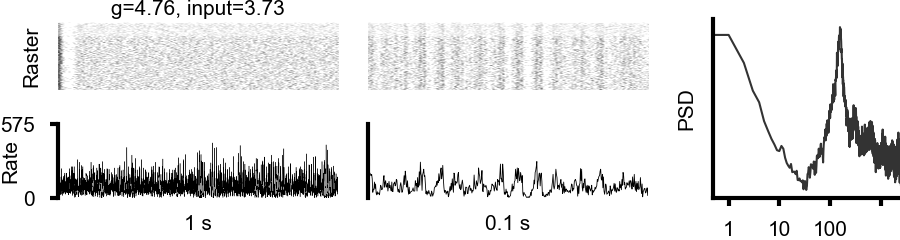

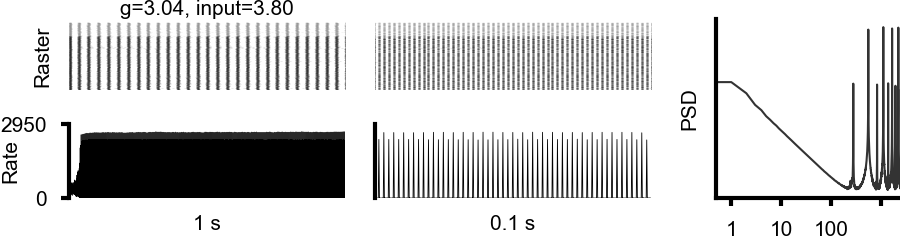

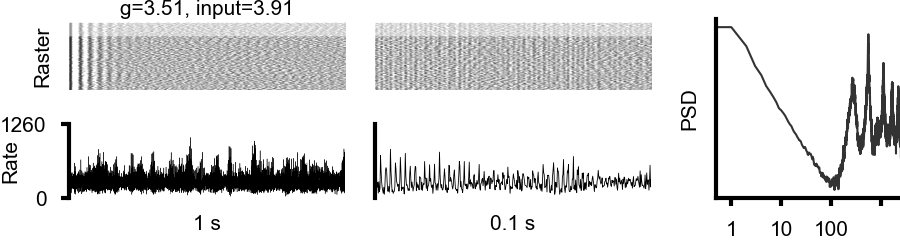

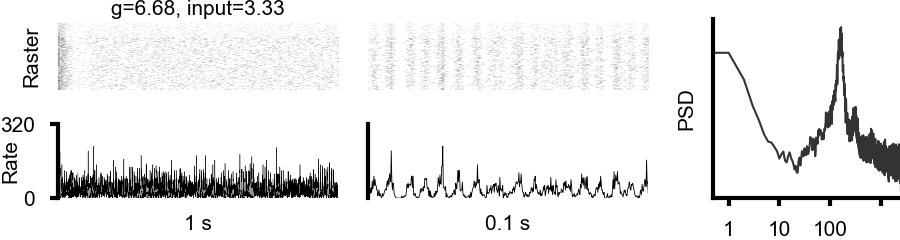

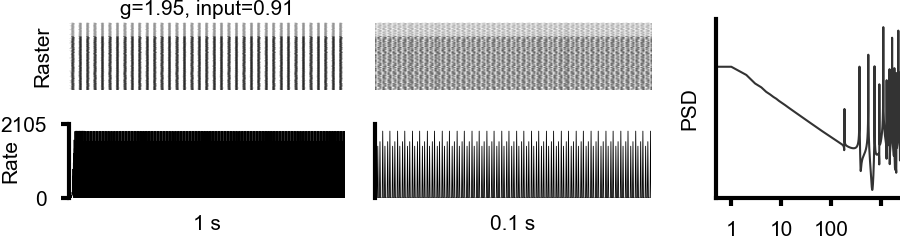

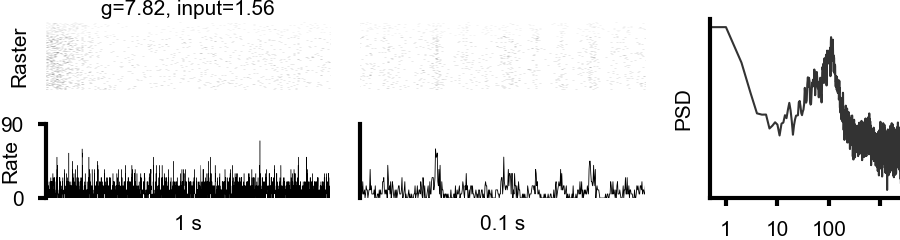

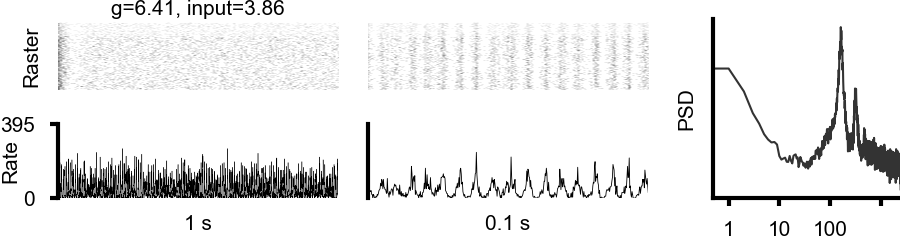

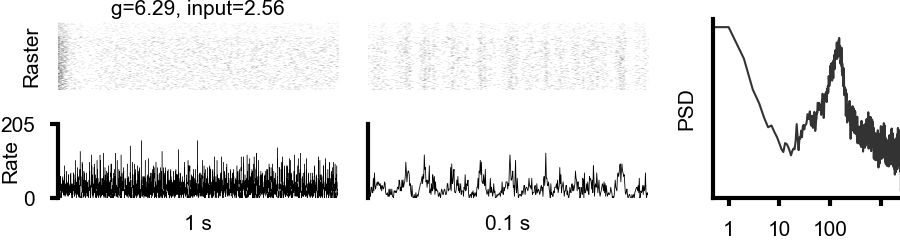

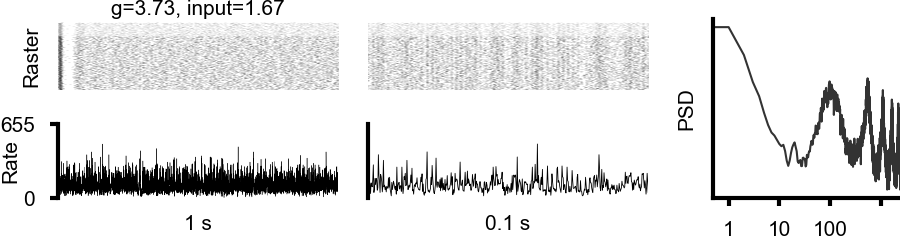

In [19]:
from matplotlib import gridspec

# Plot the results
xlims = [0, 1]
xlims_zoom = [0.1, 0.2]
every_other = 1
for i_sim, results in enumerate(summary_collector):
    if results['summary_spikes']['isi_numspks_mu'].values==0:
        continue
        
    fig = plt.figure(figsize=(3.0, .8))

    gs = gridspec.GridSpec(2, 3, width_ratios=[1.5, 1.5, 1], height_ratios=[1, 1], 
                           figure=fig, wspace=0.1, hspace=0.1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[:, 2])

    # Plot raster, rates, and PSD
    params = sim_collector[i_sim][0]
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims, every_other=10, fontsize=5, ax=ax1, ms=0.02
    )
    plot_utils._plot_rates_pretty(
        results["pop_rates"],
        XL=xlims,
        pops_to_plot=["avgpop_rate"],
        ylim_past=1 * 1000,
        fontsize=5,
        ax=ax2,
        color="k",
        lw=0.1,
    )
    ax2.set_ylabel("Rate", labelpad=-5)

    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims_zoom, every_other=every_other, fontsize=5, ax=ax3, ms=0.02
    )
    plot_utils._plot_rates_pretty(
        results["pop_rates"],
        XL=xlims_zoom,
        pops_to_plot=["avgpop_rate"],
        ylim_past=1 * 1000,
        fontsize=5,
        ax=ax4,
        color="k",
        lw=0.2
    )
    plot_utils._plot_psd_pretty(
        results["summary_psd"], ["avgpop_rate"], ax5, fontsize=5, alpha=0.8, lw=0.5
    )
    ax5.set_xlim([0.5, 2400])
    ax5.set_xticks([1, 10, 100, 1000])
    ax2.set_ylabel("Rate", labelpad=-5)
    ax3.set_ylabel("")
    ax4.set_ylabel("")
    ax4.set_yticks([])
    ax1.set_title(f"g={params['params_net']['g']:.2f}, input={params['params_net']['nu_ext']:.2f}",pad=0,)

    plt.show()

---
# That's all!

This whole workflow, with some additional checks and automation, including using hydra for path management, is included as a script in `../experiments/`.